# CS 5665 - Introduction to Data Science


## Introduction


The data used in this project is from [this](https://www.kaggle.com/c/linking-writing-processes-to-writing-quality).


### Introducing the dataset and packages


In [90]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [91]:
# Import dataset
train_df = pd.read_csv('../data/train_logs.csv')
train_scores = pd.read_csv('../data/train_scores.csv')
test_logs = pd.read_csv('../data/test_logs.csv')

In [92]:
train_df = train_df.merge(train_scores, on='id')

## Data Exploration


We are going to summarize the events per student (_id_) and use that as our new dataset. This will require exploring the data to see how to interpret the categorical variables and sum the numerical variables. We will start by evaluating the time dependent variables, the other numerical variables, and last the categorical variables.


In [93]:
train_df

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240,4.0
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240,4.0
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240,4.0
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240,4.0


In [94]:
train_df.describe()

,event_id,down_time,up_time,action_time,cursor_position,word_count,score
count,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06
mean,2.067649e+03,7.935603e+05,7.936584e+05,9.808498e+01,1.222964e+03,2.314687e+02,3.992162e+00
std,1.588284e+03,5.149451e+05,5.149428e+05,2.533985e+02,9.485242e+02,1.759088e+02,9.918788e-01
min,1.000000e+00,1.060000e+02,2.520000e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01
25%,8.520000e+02,3.731842e+05,3.732820e+05,6.600000e+01,4.990000e+02,9.600000e+01,3.500000e+00
50%,1.726000e+03,7.208860e+05,7.209800e+05,9.300000e+01,1.043000e+03,2.000000e+02,4.000000e+00
75%,2.926000e+03,1.163042e+06,1.163141e+06,1.220000e+02,1.706000e+03,3.270000e+02,4.500000e+00
max,1.287600e+04,8.313630e+06,8.313707e+06,4.474700e+05,7.802000e+03,1.326000e+03,6.000000e+00


### _down_time_, _up_time_, _action_time_ analysis


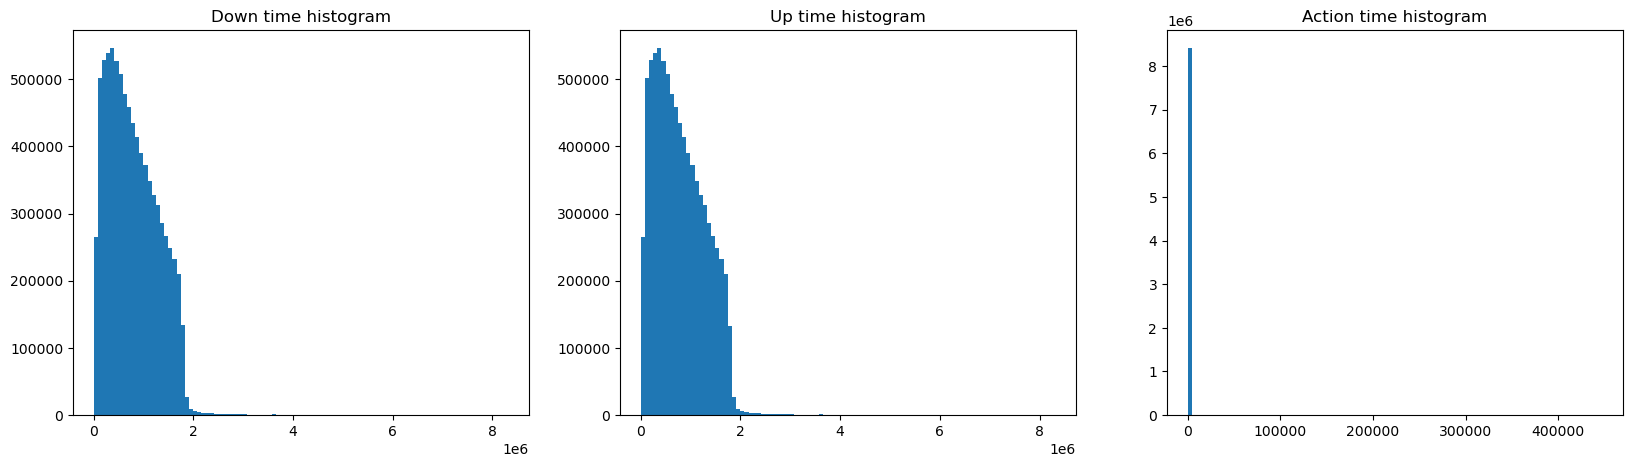

In [95]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(train_df['down_time'], bins=100)
plt.title('Down time histogram')
plt.subplot(1, 3, 2)
plt.hist(train_df['up_time'], bins=100)
plt.title('Up time histogram')
plt.subplot(1, 3, 3)
plt.hist(train_df['action_time'], bins=100)
plt.title('Action time histogram')
plt.show()

C:\Users\sarad\AppData\Local\Temp\ipykernel_11628\3843834173.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_df = temp_df.groupby('id').mean()


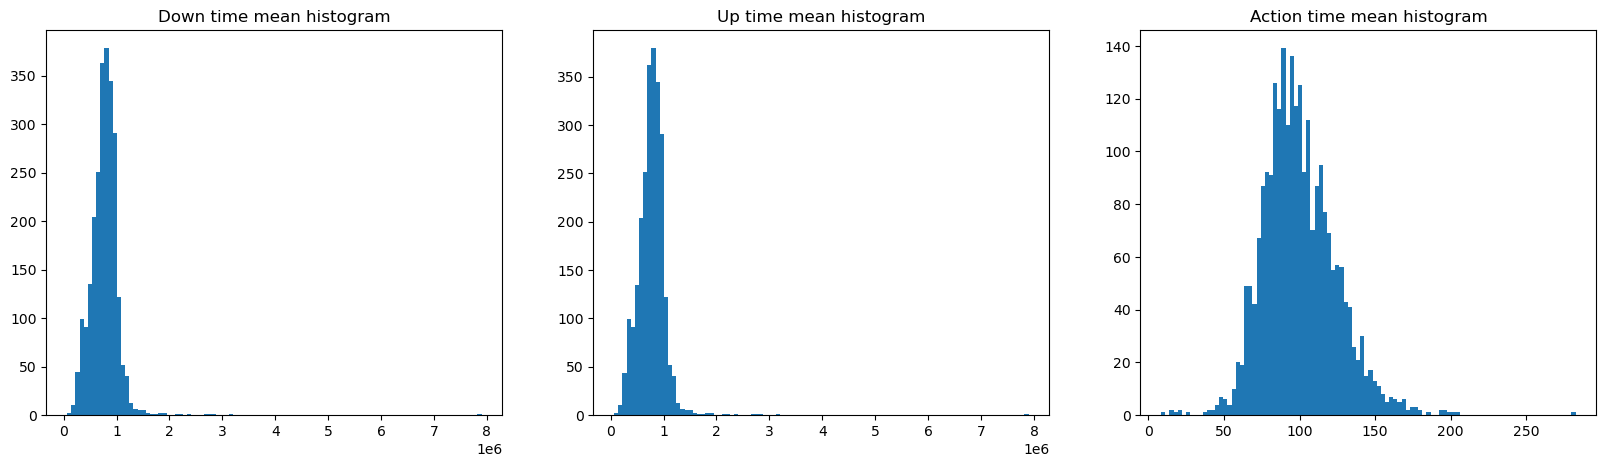

In [96]:
temp_df = train_df.copy(deep=True)
temp_df = temp_df.groupby('id').mean()
temp_df.drop(columns=['event_id'], inplace=True)
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(temp_df['down_time'], bins=100)
plt.title('Down time mean histogram')
plt.subplot(1, 3, 2)
plt.hist(temp_df['up_time'], bins=100)
plt.title('Up time mean histogram')
plt.subplot(1, 3, 3)
plt.hist(temp_df['action_time'], bins=100)
plt.title('Action time mean histogram')
plt.show()

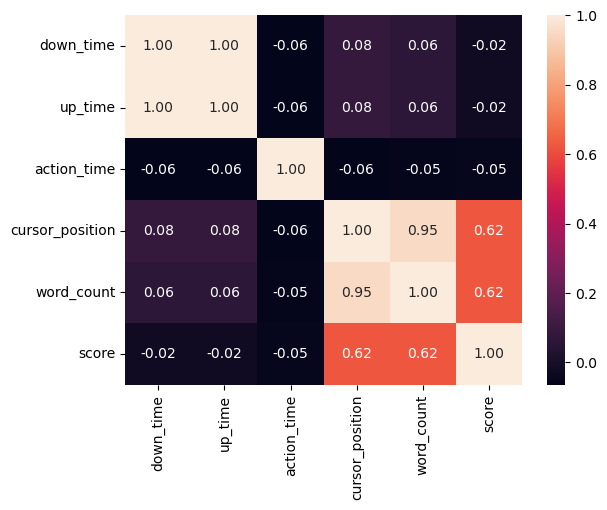

In [97]:

# find correlation between features and target
corr_matrix = temp_df.corr()

# Show a visual matrix using seaborn heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

plt.show()

_down_time_, _action_time_ will be kept, grouped by _id_, and averaged.
_up_time_ will be dropped.


### _cursor_position_ and _word_count_ analysis


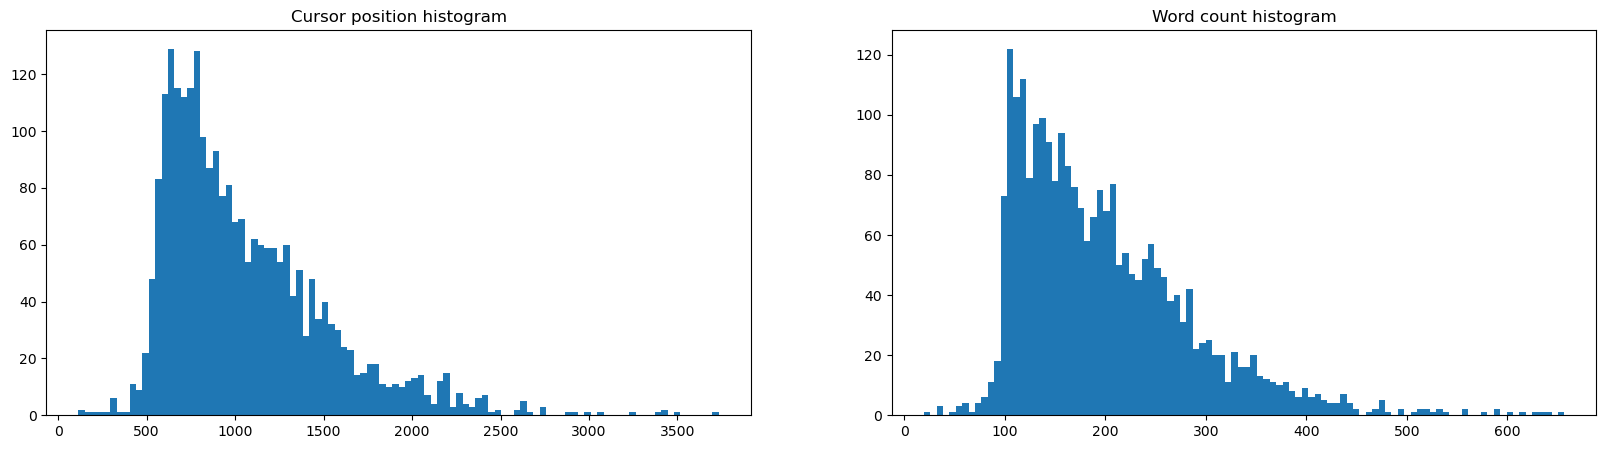

In [98]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(temp_df['cursor_position'], bins=100)
plt.title('Cursor position histogram')
plt.subplot(1, 2, 2)
plt.hist(temp_df['word_count'], bins=100)
plt.title('Word count histogram')
plt.show()

_cursor_position_ will be kept, grouped by _id_, and averaged.
_word_count_ will be dropped due to same correlation as _cursor_position_ and a less normal distribution.


### categorical variable analysis (_activity_, _up_event_, _down_event_, and _text_change_)


In [99]:
subset = train_df[['id', 'score']]

<Axes: >

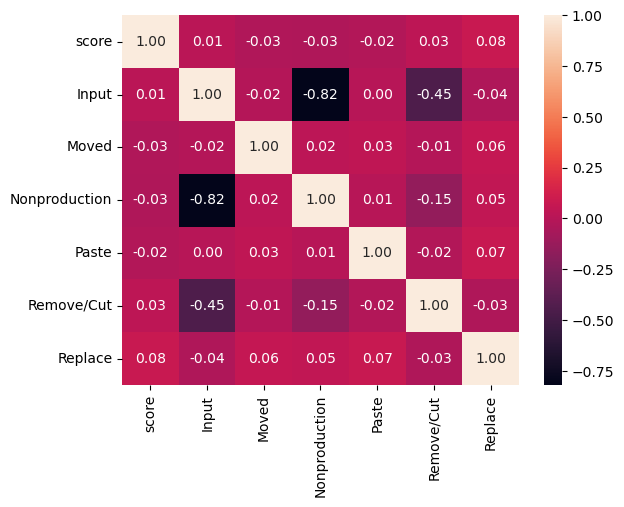

In [100]:
# Test to see if one-hot encoded would be suitable 
train_df.loc[train_df['activity'].str.contains('Move From '), 'activity'] = 'Moved'
activity_test = pd.concat([subset, pd.get_dummies(train_df['activity'])], axis=1).groupby('id').mean()
sns.heatmap(activity_test.corr(), annot=True, fmt=".2f")

_activity_ will be one hot encoded manually before grouping in order to ensure proper data manipulation


In [101]:
display(pd.DataFrame(train_df['down_event'].value_counts()).T)
display(pd.DataFrame(train_df['up_event'].value_counts()).T)
display(pd.DataFrame(train_df['text_change'].value_counts()).T)

,q,Space,Backspace,Shift,ArrowRight,Leftclick,ArrowLeft,.,",",ArrowDown,...,I,l,M,C,F,F10,Cancel,S,T,F6
down_event,5365319,1207128,964089,334227,121338,91126,63217,59586,46806,30874,...,1,1,1,1,1,1,1,1,1,1


,q,Space,Backspace,Shift,ArrowRight,Leftclick,ArrowLeft,.,",",ArrowDown,...,Å,¡,,F10,Ë,Cancel,T,S,M,F6
up_event,5364789,1207128,964089,334227,121338,91126,63217,59586,46806,30874,...,1,1,1,1,1,1,1,1,1,1


,q,,NoChange,.,",",\n,',"""",-,?,...,q q,q qqqq qqqqq qq qqqqq qqqq qq qqqqqq. qq qqq qqq qqqq qqqqq. qq'q qqqq qqqqqqqqq qq qqqq qqqq q qqqqqqq. => q,qqqqqqqqq qqqqqqqq,qqqqqqqq qqqq qq,q qqqqqqqqq => q,qqq qqqqq qqqqqqqqqq qqqqqqq qq qqqqq qqqqqqqq,qqqqqqqqq qq qqq qqqqqqqqq qq qqqq qq qqq qqqqqqqq => q,"qq qqq qqqqqqqq qqq qqq qqqqq qqqq, => q",?,\n qqqqq qqqqqq qqqqqqqqqq qq q qqqqqqqq qqq qqq qqqq qqqqqq q qqq. \n\nqqqq qqq qq qqqqqqq qqq:\n- \n- qqq qqqqqqq qqqq q qqqqqq qqqqqqqq qq qqqq qqqqqqqq
text_change,6128208,1376829,703851,67797,54797,27977,13192,4659,4492,3507,...,1,1,1,1,1,1,1,1,1,1


<Axes: >

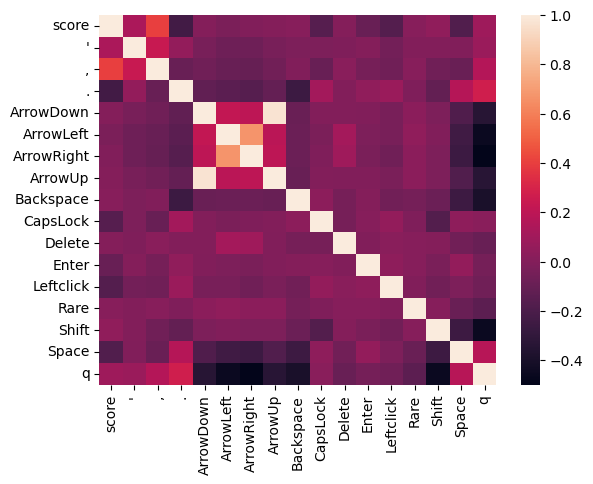

In [102]:
# Test to see if up_event is suitable for one-hot encoding, and remove the ones that rare event occurances (less than 10000)
up_event = train_df['up_event'].value_counts()
up_event = up_event[up_event > 10000]
train_df.loc[~train_df['up_event'].isin(up_event.index), 'up_event'] = 'Rare'
up_event_test = pd.concat([subset, pd.get_dummies(train_df['up_event'])], axis=1).groupby('id').mean()
sns.heatmap(up_event_test.corr(), fmt=".2f")

<Axes: >

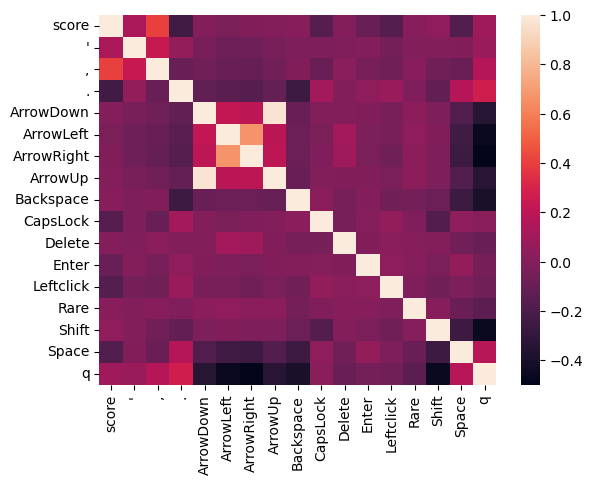

In [103]:
# Repeat the same for up_event
down_event = train_df['down_event'].value_counts()
down_event = down_event[down_event > 10000]
train_df.loc[~train_df['down_event'].isin(down_event.index), 'down_event'] = 'Rare'
down_event_test = pd.concat([subset, pd.get_dummies(train_df['down_event'])], axis=1).groupby('id').mean()
sns.heatmap(down_event_test.corr(), fmt=".2f")

There is not enough of a correlation to warrent keeping _up_event_ or _down_event_.


Repeated analysis, and tedious which is why it has been removed, for _text_change_ show that data augmentation was not helpful and this variable could be dropped.


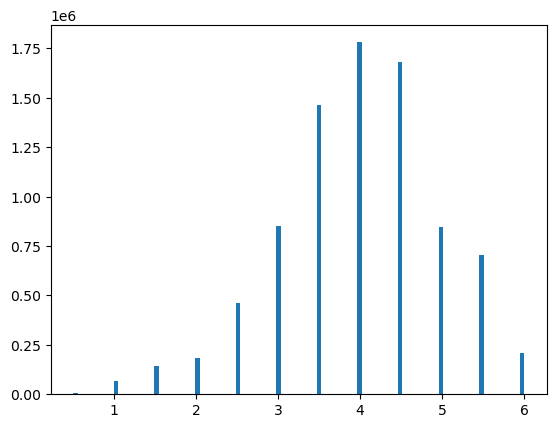

In [104]:
# distribution of 'score' to see if it needs to be transformed
plt.hist(train_df['score'], bins=100)
plt.show()


This has a noraml distribution so transformations are unnecessary.


In [105]:
# Checking for missing values
train_df.describe(include="all").loc['count']

id                   8405898
event_id           8405898.0
down_time          8405898.0
up_time            8405898.0
action_time        8405898.0
activity             8405898
down_event           8405898
up_event             8405898
text_change          8405898
cursor_position    8405898.0
word_count         8405898.0
score              8405898.0
Name: count, dtype: object

### Preprocessing


This dataset has a unique cleaning and preprocessing data process. We must first use one-hot encoding on the _activity_, group by id and get the means for each id user, then we can apply scaling. This means we will create a new function: getMeans. Then we will apply the standard scaling preprocessor.


In [106]:
def getMeans(data): 
    data = data.groupby('id').mean()
    return data

# Manual one hot encoding 
def oneHotEncode(data, col):
    data[col] = data[col].apply(lambda x: col + '_' + x)
    new_col = pd.get_dummies(data[col])
    data = pd.concat([data, new_col], axis=1)
    return pd.DataFrame(data), new_col.columns

In [107]:
train_df, scale_var_one_hot = oneHotEncode(train_df, 'activity')
train_df = getMeans(train_df)

In [110]:
passthrough_variables = ['id', 'score']
scale_variables = ['down_time', 'action_time', 'cursor_position'] + list(scale_var_one_hot)
drop_variables = ['activity', 'event_id', 'text_change', 'up_time', 'word_count']

In [111]:
preprocessor = make_column_transformer(
    ("passthrough", passthrough_variables),
    (StandardScaler(), scale_variables),
    ("drop", drop_variables)
)


In [112]:
transformed = preprocessor.fit_transform(train_df)
column_names = passthrough_variables + scale_variables

In [113]:
X_trained_transformed = pd.DataFrame(transformed, columns=column_names)
X_trained_transformed

,id,score,down_time,action_time,cursor_position,activity_Input,activity_Moved,activity_Nonproduction,activity_Paste,activity_Remove/Cut,activity_Replace
0,001519c8,3.5,-1.532269,-0.264741,-1.289334,-2.001546,-0.002339,3.307979,-0.008442,-0.361209,-0.023009
1,001519c8,3.5,-1.532207,1.207249,-1.289334,-2.001546,-0.002339,3.307979,-0.008442,-0.361209,-0.023009
2,001519c8,3.5,-1.334102,-0.387078,-1.289334,-2.001546,-0.002339,3.307979,-0.008442,-0.361209,-0.023009
3,001519c8,3.5,-1.333879,-0.02796,-1.28828,0.499614,-0.002339,-0.302299,-0.008442,-0.361209,-0.023009
4,001519c8,3.5,-1.332888,0.114109,-1.287225,0.499614,-0.002339,-0.302299,-0.008442,-0.361209,-0.023009
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,4.0,2.467028,1.570314,-0.202382,-2.001546,-0.002339,3.307979,-0.008442,-0.361209,-0.023009
8405894,fff05981,4.0,2.468102,-0.387078,-0.202382,-2.001546,-0.002339,3.307979,-0.008442,-0.361209,-0.023009
8405895,fff05981,4.0,2.468412,0.039128,-0.202382,-2.001546,-0.002339,-0.302299,-0.008442,-0.361209,43.460502
8405896,fff05981,4.0,2.477208,-0.098994,-0.205545,-2.001546,-0.002339,3.307979,-0.008442,-0.361209,-0.023009


### Splitting Data


In [ ]:
# for run time consistency, set seed
np.random.seed(42)
new_train_df, new_test_df = train_test_split(X_trained_transformed, test_size=0.2, random_state=42)

In [ ]:
# Transforming test data
test_logs.loc[test_logs['activity'].str.contains('Move From '), 'activity'] = 'Moved'

test_df, _ = oneHotEncode(test_logs, 'activity')
column_names = passthrough_variables + scale_variables

prediction_test_transformed = pd.DataFrame(transformed, columns=column_names)